
In this notebook we first create temporal clusters from a given set of images. Then we look at each temporal cluster and analyse the image similarity by using a high dimensional vector given by a CNN. The vectors of all images inside a temporal cluster are fed into a DBSCAN algorithm. By using the cosine similarity as a metric we can determine which images are similar. This way we create new near duplicate clusters that are similar in time and content.

**First section: Time based clustering of images using a similarity matrix and a novelty score**    

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from urllib.request import urlopen
from NearDuplicateCluster import NearDuplicateCluster
from GalleryImage import Base, GalleryImage
from TemporalCluster import TemporalCluster
from scipy.signal import find_peaks
from ReadImageData import readImagesFromCSV, readImagesFromDirectory, get_list_of_timestamps, transform_datetime_to_timestamp
import cv2
import os
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import math

%load_ext autoreload
%autoreload 2

First we need a set of images to work with. We are using an album of 500 images from Flickr that depict a vacation in Costa Rica.

In [ ]:
with open("costa rica.txt") as f:
    image_URLs = f.readlines()
    image_URLs = [x.strip() for x in image_URLs] 

In [ ]:
# Loading a single image
img = Image.open(urlopen(image_URLs[1]))

To start the temporal clustering we first need to order the images by their timestamp.

In [ ]:
def get_date_taken(img):
    try:
        exif_data = img._getexif()
        if 36867 in exif_data:
            image_timestamp = exif_data[36867]
            return image_timestamp
        else:
            return 0
    except AttributeError:
        return 0
    except TypeError:
        return 0

In [ ]:
# Test with one image
timestamp = get_date_taken(img)
print(timestamp)

Now we read the timestamp of all images in the album. If there is no timestamp in the EXIF data, we set the timestamp to 0.

In [ ]:
list_of_images = []

i = 0
for URL in image_URLs:
    img = Image.open(urlopen(URL))
    img_timestamp = get_date_taken(img)
    image_to_add = GalleryImage(id=i, filename=URL, timestamp=img_timestamp)
    list_of_images.append(image_to_add)
    i += 1

In [ ]:
len(list_of_images)

In [ ]:


dataframe = pd.DataFrame(columns=['id', 'timestamp', 'filename'])

for i, image in enumerate(list_of_images):
    dataframe.loc[i] = image.getData()

We save the result to a dataframe which is then saved as a .csv for later reference and faster loading of the image's information. Before saving we need to "clean" the data of unusable information (timestamps = 0).

In [ ]:
dataframe = dataframe[dataframe.timestamp != 0]
dataframe.reindex
dataframe.to_csv("image_metadata.csv" , decimal=".", sep=";", index=False)

**(Re-)start from here**

In [7]:
csv_filename = "image_metadata.csv"

list_of_images = readImagesFromCSV(csv_filename)

In [12]:
print(len(list_of_images))

print("Sample image:\n%s" % (list_of_images[0].getData()))

466
Sample image:
{'filename': 'https://farm3.staticflickr.com/2878/33919447641_e9e2cd0b46_o.jpg', 'timestamp': 1491460363}


We have 466 usable images (93% of the original album). Now the time clustering can start:  
1. Order the timestamp data
2. Create time clusters with the use of novelty scores

In [14]:
list_of_timestamps = get_list_of_timestamps(list_of_images)

list_of_timestamps.sort()

Now that we have the ordered timestamp list we can create a 2D similarity matrix with a similarity score for each timestamp combination in the list (based on *Cooper et al.*)

In [16]:
def create_similarity_matrix(list_of_timestamps):

    similarity_matrix = []
    K = 100000

    for i in range(len(list_of_timestamps)):
        similarity_matrix.append([])
        for j in range(len(list_of_timestamps)):
            similarity_value = np.exp(-(abs(list_of_timestamps[i] - list_of_timestamps[j])) / K)
            similarity_matrix[i].append(similarity_value)
            j += 1
        i += 1

    similarity_matrix = np.array(similarity_matrix)

    # Add padding of ones in the size of the kernel to correct convolution operation at the edge.
    similarity_matrix = np.pad(similarity_matrix, (6, 6), "constant", constant_values = 1)

    return similarity_matrix

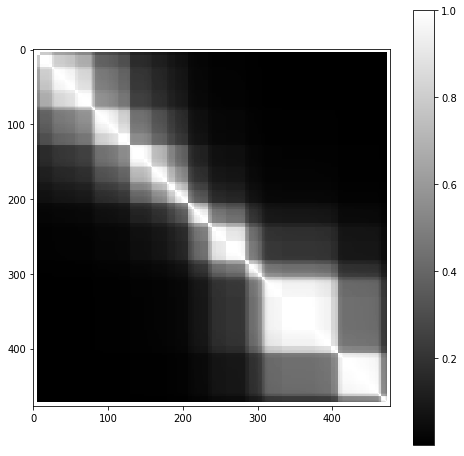

In [17]:
similarity_matrix = create_similarity_matrix(list_of_timestamps)

plt.figure(figsize=(8, 8))
plt.imshow(similarity_matrix, cmap='gray')
plt.colorbar()
plt.show()

**Novelty Score**  
The next step is to calculate novelty scores for the similarity matrix. These can then be used to identify the edges of a time cluster. The scores are calculated by correlating a (Gaussian) checkerboard kernel along the main diagonal of the similarity matrix. A checkerboard kernel has, as the name suggests, a coarse checkerboard appereance (size 6x6):  

$$ K= \left(\begin{matrix}1&1&1&-1&-1&-1\\1&1&1&-1&-1&-1\\1&1&1&-1&-1&-1\\-1&-1&-1&1&1&1\\-1&-1&-1&1&1&1\\-1&-1&-1&1&1&1\end{matrix}\right) $$  


With this kernel we can detect the transitions between the white squares of the similarity matrix and therefore detect the edges of a time cluster.

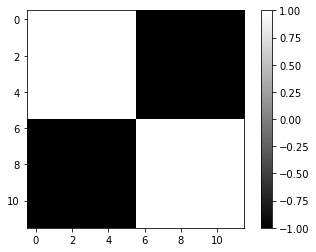

In [19]:
def createCheckerBoardKernel(kernel_size = 12):
    # Creating the matrix for the kernel
    int_size = kernel_size // 2
    C = np.array([[1, -1],
                  [-1, 1]])

    ones = np.ones(shape=(int_size, int_size))

    checkerboard_kernel = np.kron(C, ones)

    if kernel_size % 2 != 0:
        checkerboard_kernel = np.insert(checkerboard_kernel, int_size, np.array(np.zeros(shape=(1, checkerboard_kernel.shape[0]))), 0)
        checkerboard_kernel = np.insert(checkerboard_kernel, int_size, np.array(np.zeros(shape=(1, checkerboard_kernel.shape[0]))), 1)

    return checkerboard_kernel

kernel_size = 12
padding_size = kernel_size // 2
checkerBoardKernel = createCheckerBoardKernel(kernel_size)

In [20]:
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

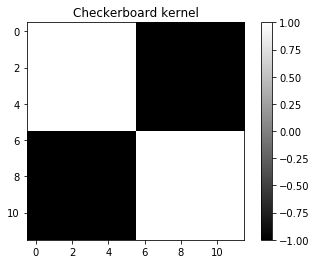

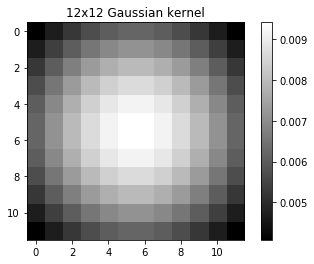

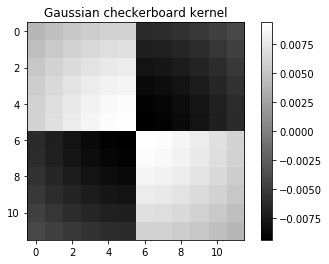

In [22]:
# Smooth the kernel to avoid edge effects. Sigma is chosen in a way that the outer most pixels of the kernel are zero.

plt.imshow(checkerBoardKernel, cmap='gray')
plt.title("Checkerboard kernel")
plt.colorbar()
plt.show()

gauss_kernel = matlab_style_gauss2D(shape=(12, 12), sigma=6)

plt.imshow(gauss_kernel, cmap='gray')
plt.title("12x12 Gaussian kernel")
plt.colorbar()
plt.show()

# Creating the Gaussian checkerboard kernel that is used for the calculation of the novelty scores
gaussian_checkerboard_kernel = np.multiply(checkerBoardKernel, gauss_kernel)

plt.imshow(gaussian_checkerboard_kernel, cmap='gray')
plt.title("Gaussian checkerboard kernel")
plt.colorbar()
plt.show()

Now we can calculate a novelty score for each timestamp. By applying the Gaussian checkerboard kernel we get high values when the two considered regions on each side of the checkerboard are self-similar but different from each other.

In [23]:
def calculateNoveltyScore(timestamp_index, padding_size, similarity_matrix, gaussian_checkerboard_kernel):

    # Used to start from "center" of kernel
    half_size = padding_size

    novelty_score = 0

    for row_index in range(-half_size, half_size):
        sum_of_product = 0

        for column_index in range(-half_size, half_size):
            matrix_value = similarity_matrix[timestamp_index + row_index][timestamp_index + column_index]
            kernel_value = gaussian_checkerboard_kernel[half_size + row_index][half_size + column_index]

            product = matrix_value * kernel_value

            sum_of_product += product
        novelty_score += sum_of_product

    return novelty_score

In [28]:
novelty_scores = []

# Start from the new index (old first index + padding_size), end at length of diagonal of similarity matrix + padding.
for i in range(padding_size, len(list_of_timestamps) + padding_size):
    novelty_scores.append(calculateNoveltyScore(i, padding_size, similarity_matrix, gaussian_checkerboard_kernel))

print(len(novelty_scores))

# Find peaks in novelty scores:
novelty_scores = np.asarray(novelty_scores)
peaks, _ = find_peaks(novelty_scores, height=novelty_scores.mean())

466


In [ ]:
# Subplot figure to visualize results
def plotResult(similarity_matrix, novelty_scores):
    fig, axs = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 8))

    axs[0].set_title("Similarity Matrix")
    axs[0].imshow(similarity_matrix[padding_size:,padding_size:], cmap="gray", aspect="auto")
    axs[0].set_xlim([0, len(timestamp_list) - 1])
    axs[0].set_xticks(np.arange(0, len(timestamp_list), step=50))
    axs[0].set_ylim(bottom=len(timestamp_list) - 1)

    axs[1].set_title("Novelty scores")
    axs[1].plot(novelty_scores)
    axs[1].set_xlim([0, len(timestamp_list) - 1])
    axs[1].set_xticks(np.arange(0, len(timestamp_list), step=50))
    axs[1].set_xlabel('Image index')
    axs[1].set_ylim(bottom=0)

    plt.show()

plotResult(similarity_matrix, novelty_scores)

Now that we have our novelty scores we can identify the edges of a temporal cluster by looking at the peaks of the diagram. Programmatically, we can identify them by calculating the difference of each novelty score.

In [29]:
def createClustersBasedOnPeaks(list_of_images, peaks):
    list_of_clusters = []
    image_index = 0
    while image_index < len(list_of_images) - 1:
        if image_index == 0:
            temporal_cluster = []
            temporal_cluster.append(image_index)
        else:
            if image_index not in peaks:
                temporal_cluster.append(image_index)
            else:
                if len(list_of_clusters) == 0:
                    list_of_clusters.append(temporal_cluster)
                temporal_cluster = []
                temporal_cluster.append(image_index)
                for inner_image_index in range(image_index + 1, len(list_of_images)):
                    if inner_image_index not in peaks:
                        temporal_cluster.append(inner_image_index)

                        # Last temporal cluster
                        if inner_image_index == len(list_of_images) - 1:
                            list_of_clusters.append(temporal_cluster)
                            image_index = inner_image_index - 1
                            break
                    else:
                        if len(temporal_cluster) >= 1:
                            list_of_clusters.append(temporal_cluster)
                        image_index = inner_image_index - 1
                        break
        image_index += 1
    return list_of_clusters

list_of_clusters = createClustersBasedOnPeaks(list_of_images, peaks)

In [30]:
# To store the found temporal clusters inside a database we need custom objects

def createTemporalClusterObjects(list_of_images, peaks):
    list_of_temporal_clusters = []
    list_of_clusters = createClustersBasedOnPeaks(list_of_images, peaks)
    for i, cluster in enumerate(list_of_clusters):
        timestamp_list = []
        image_ids_list = ""
        for image_id in cluster:
            timestamp_list.append(list_of_images[image_id].timestamp)
            if image_id != cluster[len(cluster) - 1]:
                # As the auto-increment value for the corresponding GalleryImage in the database starts at 1 we need to
                # increment the value by 1
                image_ids_list += str(image_id + 1) + ","
            else:
                image_ids_list += str(image_id + 1)

        timestamp_array = np.asarray(timestamp_list)
        temporal_cluster = TemporalCluster(image_ids_list, len(cluster), int(np.median(timestamp_array)))
        list_of_temporal_clusters.append(temporal_cluster)

    return list_of_temporal_clusters

In [31]:
temporal_clusters = createTemporalClusterObjects(list_of_images, peaks)

The next section is for defining the database functions

In [32]:
def loadSession():
    db_engine = create_engine("sqlite:///clustering.db")
    Base.metadata.bind = db_engine
    Base.metadata.create_all(db_engine)

    DBSession = sessionmaker(bind=db_engine)
    session = DBSession()

    return session

def saveImagesToDatabase(session, list_of_images):

    session.add_all(list_of_images)
    try:
        session.commit()
    except:
        session.rollback()

# TODO: When saving temporal clusters it is necessary to read and reserve the last image id in the database before adding new images. Then we can save the temporal clusters correctly.
def saveTemporalClustersToDatabase(session, list_of_temporal_clusters):
    session.add_all(list_of_temporal_clusters)
    try:
        session.commit()
    except:
        session.rollback()

In [34]:
session = loadSession()

saveImagesToDatabase(session, list_of_images)
saveTemporalClustersToDatabase(session, createTemporalClusterObjects(list_of_images, peaks))